In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import sys
import sklearn.pipeline
import sklearn.preprocessing

if "../" not in sys.path:
  sys.path.append("../") 

from lib import plotting
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import RBFSampler

matplotlib.style.use('ggplot')

In [2]:
env = gym.envs.make("MountainCar-v0")

[2017-07-09 10:33:55,642] Making new env: MountainCar-v0


In [3]:
# Feature Preprocessing: Normalize to zero mean and unit variance
# We use a few samples from the observation space to do this
# NOTE: env.observation_space.sample() produces outputs like array([-0.21213569,  0.03012651])
observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(observation_examples)

# Used to convert a state to a featurized representation.
# We use RBF kernels with different variances to cover different parts of the space
featurizer = sklearn.pipeline.FeatureUnion([
        ("rbf1", RBFSampler(gamma=5.0, n_components=100)),
        ("rbf2", RBFSampler(gamma=2.0, n_components=100)),
        ("rbf3", RBFSampler(gamma=1.0, n_components=100)),
        ("rbf4", RBFSampler(gamma=0.5, n_components=100))
        ])
featurizer.fit(scaler.transform(observation_examples))

FeatureUnion(n_jobs=1,
       transformer_list=[('rbf1', RBFSampler(gamma=5.0, n_components=100, random_state=None)), ('rbf2', RBFSampler(gamma=2.0, n_components=100, random_state=None)), ('rbf3', RBFSampler(gamma=1.0, n_components=100, random_state=None)), ('rbf4', RBFSampler(gamma=0.5, n_components=100, random_state=None))],
       transformer_weights=None)

In [4]:
class Estimator():
    """
    Value Function approximator. 
    """
    
    def __init__(self, alpha=None):
        # We create a separate model for each action in the environment's
        # action space. Alternatively we could somehow encode the action
        # into the features, but this way it's easier to code up.
        self.models = []
        for _ in range(env.action_space.n):
            if alpha is None:
                model = SGDRegressor(learning_rate="constant")
                print("No alpha value set")
            else:
                model = SGDRegressor(learning_rate="constant", eta0=alpha)
            # We need to call partial_fit once to initialize the model
            # or we get a NotFittedError when trying to make a prediction
            # This is quite hacky.
            model.partial_fit([self.featurize_state(env.reset())], [0])
            self.models.append(model)
    
    def featurize_state(self, state):
        """
        Returns the featurized representation for a state.
        """
        scaled = scaler.transform([state])
        featurized = featurizer.transform(scaled)
        return featurized[0]
    
    def predict(self, s, a=None):
        """
        Makes value function predictions.
        
        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for
            
        Returns
            If an action a is given this returns a single number as the prediction.
            If no action is given this returns a vector or predictions for all actions
            in the environment where pred[i] is the prediction for action i.
            
        """
        s_featurized = self.featurize_state(s)
        
        # TODO: Implement this!
        if a is None:
            predictions = np.zeros(env.action_space.n)
            
            for i, action_model in enumerate(self.models):
                predictions[i] = action_model.predict([s_featurized])
                
            return predictions
        else:
            return self.models[a].predict([s_featurized])[0]
    
    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """
        # TODO: Implement this!
        s_featurized = self.featurize_state(s)
        self.models[a].partial_fit([s_featurized], [y])

In [5]:
def make_epsilon_greedy_policy(estimator, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.
    
    Args:
        estimator: An estimator that returns q values for a given state
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(observation)
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [6]:
def sarsa_fa(env, estimator, num_episodes, discount_factor=1.0, epsilon=0.1, epsilon_decay=1.0):
    """
    Q-Learning algorithm for off-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    
    Args:
        env: OpenAI environment.
        estimator: Action-Value function estimator
        num_episodes: Number of episodes to run for.
        discount_factor: Lambda time discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    for i_episode in range(num_episodes):
        
        # The policy we're following
        policy = make_epsilon_greedy_policy(
            estimator, epsilon * epsilon_decay**i_episode, env.action_space.n)
        
        # Print out which episode we're on, useful for debugging.
        # Also print reward for last episode
        last_reward = stats.episode_rewards[i_episode - 1]
        print("\rEpisode {}/{} ({})".format(i_episode + 1, num_episodes, last_reward), end="")
        sys.stdout.flush()
        
        # The very first state(== observation)
        observation = env.reset()

        # Select the first action given the first state
        action = np.random.choice(env.action_space.n, p=policy(observation))

        # We are naively assuming finite lengths of episodes here.
        # Using while loop like this might lead to infinite loop
        # depending on environments. Adding measures to enforce
        # finite number of iterations might be useful.     
        episode_finished = False

        while not episode_finished:
            # Update the total number of steps in this episode (for stats purposes)
            stats.episode_lengths[i_episode] += 1
            
            # Need to backup the current state before moving on
            # to do the lookahead
            prev_observation = observation

            # Record the result of the action
            observation, reward, done, _ = env.step(action)

            # Update the total reward obtained from this episode (for stats purposes)
            stats.episode_rewards[i_episode] += reward
            
            if done:
                # If we receive 'done' signal, let's finish up the episode
                episode_finished = True

                # When we reached the terminal state, there is no more future state-actions
                # In the value table lookup version, we updated using the following statement:
                # Q[prev_observation][action] += alpha * (reward - Q[prev_observation][action])
                estimator.update(prev_observation, action, reward)
                
            else:
                # Select next action in advance to do the lookahead
                next_action = np.random.choice(env.action_space.n, p=policy(observation))

                # In the value table lookup version, we updated using the following statement:
                # Q[prev_observation][action] += alpha * (
                #     reward + discount_factor * Q[observation][next_action] - Q[prev_observation][action]
                # )
                estimator.update(
                    prev_observation,
                    action,
                    # Target
                    reward + discount_factor * estimator.predict(observation, next_action)
                )

                # We will do the next_action at the next iteration
                action = next_action
    return stats

In [7]:
# You can set the alpha value here and pass it to Estimator(). 
# Note that the default value set by SGDRegressor is 0.01.
estimator = Estimator(alpha=None)

No alpha value set
No alpha value set
No alpha value set


In [8]:
# Note: For the Mountain Car we don't actually need an epsilon > 0.0
# because our initial estimate for all states is too "optimistic" which leads
# to the exploration of all states.
stats = sarsa_fa(env, estimator, 1000, epsilon=0.0)

Episode 1000/1000 (-132.0)

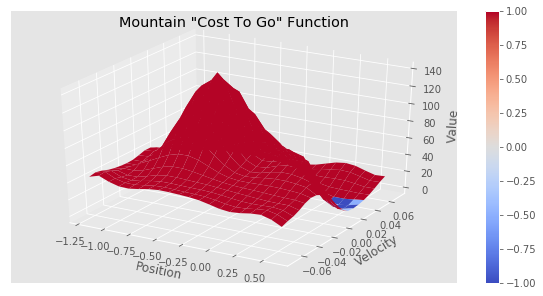

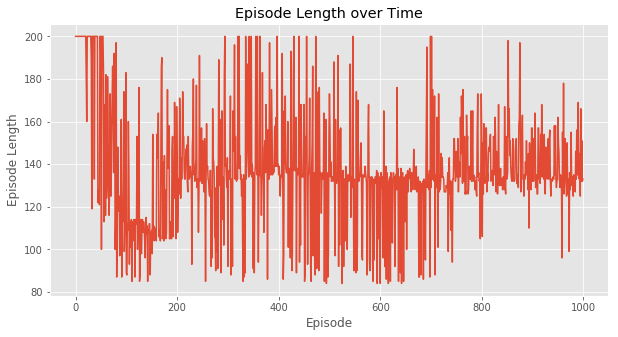

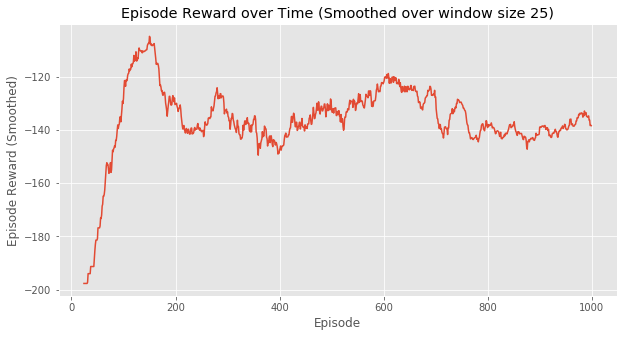

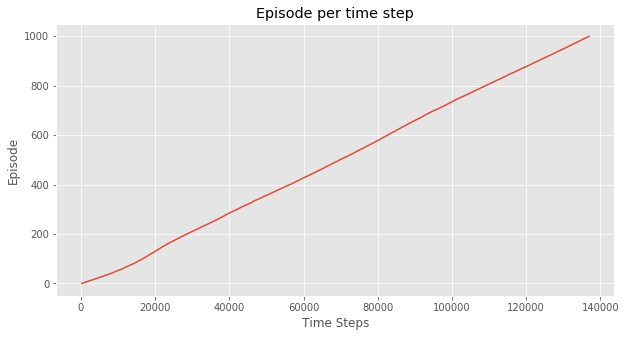

(<matplotlib.figure.Figure at 0x10aaea898>,
 <matplotlib.figure.Figure at 0x10ae64e80>)

In [9]:
plotting.plot_cost_to_go_mountain_car(env, estimator)
plotting.plot_episode_stats(stats, smoothing_window=25)